## Triplet loss training
Here, we visualize intrinsic performance metrics of the triplet loss models.
We will compare loss and accuracy in author discrimination between a baseline DistilBERT model and the same model after fine tuning on two versions of the triplet loss task, that differ for the number of anchor posts the model is provided with (1 vs. batches of up to 10 posts). 
We also dig deeper into the behavior of the model, looking more closely into:
- How model performance varies as a function of the size of the anchor;
- How model performance varies as a function of the average length of the posts;
- Digging deeper into qualitative performance examples

In [14]:
import gzip
from reddit.utils import load_tfrecord
import json
import numpy as np
from pathlib import Path
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
import random
from IPython.display import Markdown, display
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

### Loss and accuracy
Let's start from inspecting how loss and performance change over training

In [15]:
def _make_path(model_name):
    MPATH = Path(f'../logs/triplet/{model_name}/standard/metrics/batch_transformer/')
    MPATH = MPATH / 'triplet_loss_margin-1.0'
    return MPATH

def _get_metrics(overall_dict, model_name, model_id):
    d = {}
    MPATH = _make_path(model_name)
    for i in range(3):
        d[f'epoch-{str(i)}'] = json.load(open(_make_path(model_name) /
                                              f'epoch-{str(i)}' / 
                                              'log.json'))
    d['baseline_validation'] = json.load(open(_make_path(model_name+'_baseline_validation')/ 
                                              f'epoch-test_only' / 
                                              'log.json'))
    d['baseline_test'] = json.load(open(_make_path(model_name+'_baseline_test')/
                                        f'epoch-test_only' / 
                                        'log.json'))
    d['trained_test'] = json.load(open(_make_path(model_name+'_test')/
                                        f'epoch-test_only' / 
                                        'log.json'))
    overall_dict.update({model_id: d})
    return overall_dict

def _make_summary_metrics(overall_dict):
    summaries = []
    for model_id in overall_dict.keys():
        baseline_validation_set = np.mean(overall_dict[model_id][f'baseline_validation']['test_metrics'])
        baseline_test_set = np.mean(overall_dict[model_id][f'baseline_test']['test_metrics'])
        trained_training_set = np.mean(overall_dict[model_id][f'epoch-0']['metrics'])
        trained_validation_set = np.mean(overall_dict[model_id][f'epoch-0']['test_metrics'])
        trained_test_set = np.mean(overall_dict[model_id][f'trained_test']['test_metrics'])
        summaries += [{'anchors': model_id,
                       'model_id': 'baseline',
                       'split': 'validation', 
                       'performance': baseline_validation_set},
                      {'anchors': model_id,
                       'model_id': 'baseline',
                       'split': 'test', 
                       'performance': baseline_test_set},
                      {'anchors': model_id,
                       'model_id': 'trained',
                       'split': 'validation', 
                       'performance': trained_validation_set},
                      {'anchors': model_id,
                       'model_id': 'trained',
                       'split': 'test', 
                       'performance': trained_test_set}]
    return pd.DataFrame(summaries)

In [16]:
overall_dict = _get_metrics({}, 'final_1anchor', '1anchor')
overall_dict = _get_metrics(overall_dict, 'final_10anchor', '10anchor')
df = _make_summary_metrics(overall_dict)
print(df)

    anchors  model_id       split  performance
0   1anchor  baseline  validation     0.679440
1   1anchor  baseline        test     0.678683
2   1anchor   trained  validation     0.838407
3   1anchor   trained        test     0.837038
4  10anchor  baseline  validation     0.736707
5  10anchor  baseline        test     0.735949
6  10anchor   trained  validation     0.931173
7  10anchor   trained        test     0.930551


### Visualize performance

Percentage correct over epochs (grey line is test performance)

In [17]:
sns.set_style('whitegrid')

In [18]:
n_ex = len(overall_dict['1anchor']['epoch-0']['losses'])
avg_by = 1000
mtrs_idx = list(np.arange(0, n_ex, avg_by))

In [19]:
def _roll_avg(lst):
    return [np.mean(lst[mtrs_idx[i]:mtrs_idx[i+1]]) for i in range(len(mtrs_idx)-1)]

<ipython-input-20-21bb71f8c270>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels=[int(l)*1000 for l in ax[i].get_xticks()])
<ipython-input-20-21bb71f8c270>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels=[int(l)*1000 for l in ax[i].get_xticks()])


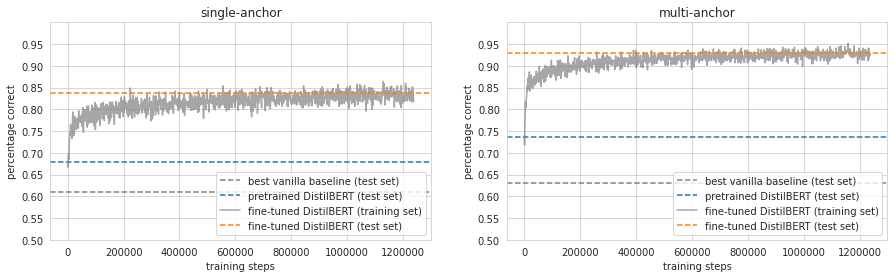

In [20]:
f, ax = plt.subplots(ncols=2, figsize=(15,4))
titles = ['single-anchor', 'multi-anchor']
baselines = [.61, .63]
m = 'metrics'
for i, k in enumerate(['1anchor', '10anchor']):
    mtrs = _roll_avg(overall_dict[k][f'epoch-0'][m])
    mean_test = np.mean(overall_dict[k][f'trained_test'][f'test_{m}'])
    mean_pretrained = np.mean(overall_dict[k][f'baseline_test'][f'test_{m}'])
    ax[i].set_xlabel('training steps')
    ax[i].set_ylabel('percentage correct')
    ax[i].set_ylim(.5,1)
    ax[i].set_title(titles[i])
    ax[i].axhline(baselines[i], ls='--', 
                  color='grey',
                  label='best vanilla baseline (test set)')
    ax[i].axhline(mean_pretrained, ls='--', 
                  color=sns.color_palette()[0],
                  label='pretrained DistilBERT (test set)')
    sns.lineplot(x=range(len(mtrs)), 
                 y=mtrs, 
                 color='grey',
                 ax=ax[i], 
                 label='fine-tuned DistilBERT (training set)',
                 alpha=.7)
    ax[i].axhline(mean_test,  ls='--', 
                  color=sns.color_palette()[1],
                  label='fine-tuned DistilBERT (test set)')
    ax[i].legend(loc='lower right')
    ax[i].set_yticks(np.arange(.5,1,.05))
    ax[i].set_xticklabels(labels=[int(l)*1000 for l in ax[i].get_xticks()])
plt.show()

### Visualize distances

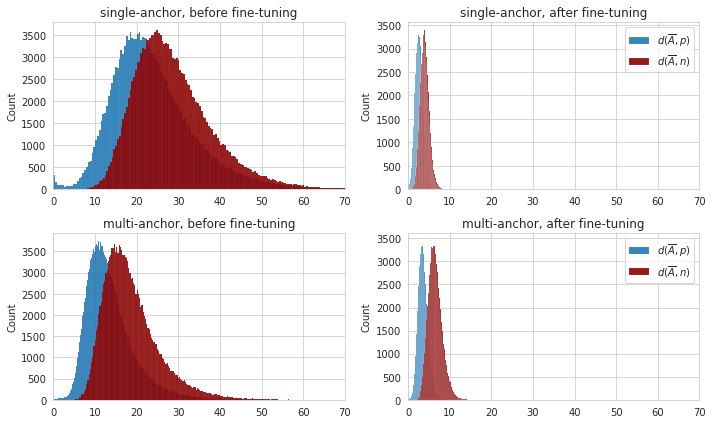

In [21]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
titles_training = ['before fine-tuning', 'after fine-tuning']
for mid, m in enumerate(['1anchor', '10anchor']):
    for idx, k in enumerate(['baseline_test','trained_test']):
        sns.histplot(x=overall_dict[m][k]['test_dist_pos'],
                     color=sns.color_palette()[0],
                     alpha=.9, 
                     ax=ax[mid, idx], 
                     label=r'$d(\overline{A}, p)$')
        sns.histplot(x=overall_dict[m][k]['test_dist_neg'],
                     color='darkred',
                     alpha=.9, 
                     ax=ax[mid, idx], 
                     label=r'$d(\overline{A}, n)$')
        ax[mid, idx].set_xlim(0,70)
        ax[mid,idx].set_title(k)
        if idx == 1:
            ax[mid,idx].legend()
        ax[mid, idx].set_title(f'{titles[mid]}, {titles_training[idx]}')
plt.tight_layout()
plt.show()

### Dissect model performance as a function of text characteristics

Let's start from visualizing performance as a function of the number of posts

In [22]:
# Get number of posts and whether there's an overlap in subreddits
JSON_PATH = Path('../reddit/data/json/triplet/1pos_1neg_random/')
json_files = glob.glob(str(JSON_PATH / 'test' / '*'))
test_ids = overall_dict['1anchor']['trained_test']['test_example_ids']
ad = {} # Dictionary of author id, number of posts, and whether there's an overlap in subreddits
skip_files = []
for idx, f in enumerate(json_files): # load each file
    batch = json.load(gzip.open(f))
    batch = [{'author_id': int(b['author_id']), # just keep relevant fields
              'n_posts': np.min([len(b['anchor']), 10]),
              'pos_subreddit_overlap': b['pos_subreddit_overlap'],
              'neg_subreddit_overlap': b['neg_subreddit_overlap'],
              'pos_subreddit_overlap_1anchor': float(b['anchor_subreddits'][0] == b['positive_subreddits'][0]),
              'neg_subreddit_overlap_1anchor': float(b['anchor_subreddits'][0] == b['negative_subreddits'][0])} for b in batch]
    batch_df = pd.DataFrame(batch)
    subs_df = batch_df[batch_df['author_id'].isin(test_ids)]
    if subs_df.shape[0] == 0:
        skip_files.append(f.split('/')[-1].strip('.json.gz'))
    else:
        ad.update(subs_df.set_index('author_id').to_dict('index'))
        
# Now get text length
tf_files = glob.glob('../reddit/data/datasets/triplet/1pos_1neg_random/test/*')
tf_files = [t for t in tf_files if not t.split('/')[-1].split('-')[0] in skip_files]
tf_ds = load_tfrecord(tf_files, ds_type='triplet')
for e in tf_ds:
    if e['author_id'].numpy() in ad.keys():
        nz = np.mean(tf.math.count_nonzero(e['iids'][:10,:], axis=1))
        ad[e['author_id'].numpy()]['mean_token_length'] = nz 
        ad[e['author_id'].numpy()]['first_token_length'] = np.mean(tf.math.count_nonzero(e['iids'][:1,:], axis=1))
        
# Now, for each post, let's see how it's classified
for k in ['1anchor', '10anchor']:
    for e_idx in range(len(overall_dict[k][f'trained_test']['test_metrics'])):
        a_id = overall_dict[k][f'trained_test']['test_example_ids'][e_idx]
        if a_id in ad.keys():
            ad[a_id][f'{k}_metric'] = overall_dict[k]['trained_test']['test_metrics'][e_idx]
            ad[a_id][f'{k}_metric_baseline'] = overall_dict[k][f'baseline_test']['test_metrics'][e_idx]
adf = pd.DataFrame(ad).T.reset_index()

In [23]:
n_posts = adf[['n_posts', 
               '10anchor_metric_baseline',
               '10anchor_metric', 
               ]].groupby('n_posts').agg('mean').reset_index()
n_posts = n_posts.melt(id_vars='n_posts')
n_posts['n_posts'] = n_posts['n_posts'].astype(int)
n_posts['variable'] = n_posts['variable'].replace({'10anchor_metric_baseline': 'before fine-tuning',
                                                  '10anchor_metric': 'after fine-tuning'}) 

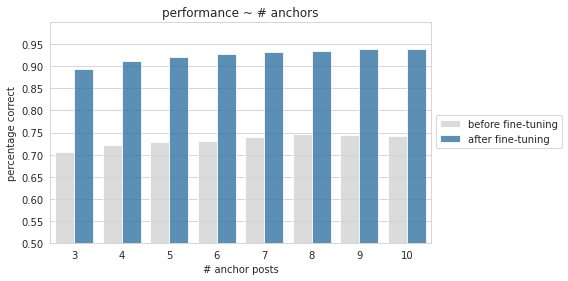

In [24]:
fig, ax = plt.subplots(figsize=(8,3.8))
sns.barplot(data=n_posts, x='n_posts', y='value', hue='variable', 
            dodge=True, palette=['lightgrey', sns.color_palette()[0]], 
            alpha=.8)
plt.legend(title=None, ncol=1, frameon=True, bbox_to_anchor=(1,.6))
plt.ylim(.6,1.)
plt.yticks(np.arange(.5,1,.05))
plt.tight_layout()
plt.xlabel('# anchor posts')
plt.ylabel('percentage correct')
plt.title('performance ~ # anchors')
plt.show()

#### Performance ~ same/difference subreddit

In [25]:
overlap = adf.groupby('pos_subreddit_overlap')[['10anchor_metric_baseline',
                                                '10anchor_metric']].mean().reset_index()
overlap_1anchor = adf.groupby('pos_subreddit_overlap_1anchor')[['1anchor_metric_baseline',
                                                        '1anchor_metric']].mean().reset_index()
overlap_1anchor.columns = ['subreddit_overlap', 'performance_before_fine-tuning', 'performance_after_fine-tuning']
overlap_1anchor['n_anchors'] = 1
overlap['n_anchors'] = 10
overlap.columns = overlap_1anchor.columns
overlap = pd.concat([overlap, overlap_1anchor], ignore_index=True)
# overlap = overlap.melt(id_vars=['subreddit_overlap', 'n_anchors'])

In [26]:
overlap

,subreddit_overlap,performance_before_fine-tuning,performance_after_fine-tuning,n_anchors
0,0.0,0.710428,0.913177,10
1,1.0,0.764276,0.949834,10
2,0.0,0.662355,0.826349,1
3,1.0,0.801814,0.917648,1


#### Performance ~ avg length (in tokens)

In [27]:
ints = np.arange(0,540,10)
labels = [i for i in ints[1:]]
adf['token_bins'] = pd.cut(adf['mean_token_length'], 
                           bins=ints,
                           labels=labels)
adf['token_bins_first'] = pd.cut(adf['first_token_length'], 
                                 bins=ints,
                                 labels=labels)

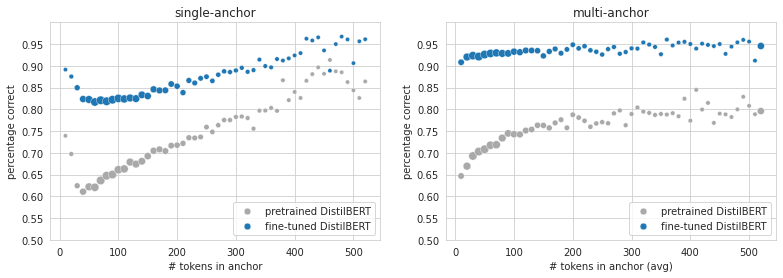

In [28]:
cols = ['token_bins', 'token_bins_first']
xlabs = ['# tokens in anchor', '# tokens in anchor (avg)']
fig, ax = plt.subplots(figsize=(13,4), ncols=2, nrows=1)
for i, n in enumerate(['1', '10']):
    token_bins = adf.groupby(cols[i])[[f'{n}anchor_metric_baseline',
                                            f'{n}anchor_metric']].agg(['mean', 'count']).reset_index()
    token_bins.columns = [cols[i], 
                          f'{n}anchor_metric_baseline_mean', 
                          f'{n}anchor_metric_baseline_count',
                          f'{n}anchor_metric_mean', 
                          f'{n}anchor_metric_count',
                         ]
    p1 = sns.scatterplot(data=token_bins, x=cols[i], y=f'{n}anchor_metric_baseline_mean', 
                    size=f'{n}anchor_metric_baseline_count', 
                    label='pretrained DistilBERT',
                    color='darkgrey',  
                    ax=ax[i])
    p2 = sns.scatterplot(data=token_bins, x=cols[i], y=f'{n}anchor_metric_mean',
                    size=f'{n}anchor_metric_count', ax=ax[i], 
                    label='fine-tuned DistilBERT',)
    ax[i].set_xlabel(xlabs[i])
    ax[i].set_ylabel('percentage correct')
    if i==1:
        lix = 6
    else:
        lix = 7
    ax[i].legend(handles = [ax[i].legend().legendHandles[0],
                            ax[i].legend().legendHandles[lix]],
                loc='lower right')
    #else:
    #    ax[i].legend().remove()
    ax[i].set_title(titles[i])
    ax[i].set_ylim(.5,1)
    ax[i].set_yticks(np.arange(.5,1,.05))


### Visualize some examples - multi-anchor

In [33]:
both_ids = [k for k,v in ad.items() if (v['10anchor_metric_baseline'] == 0.0) & \
                                            (v['1anchor_metric_baseline'] == 0.0) & \
                                            (v['10anchor_metric'] == 1.0) & \
                                            (v['1anchor_metric'] == 1.0)]
learned_10_ids = [k for k,v in ad.items() if (v['10anchor_metric_baseline'] == 0.0) & \
                                          (v['1anchor_metric_baseline'] == 0.0) & \
                                          (v['10anchor_metric'] == 1.0) & \
                                          (v['1anchor_metric'] == 0.0)]
learned_1_ids = [k for k,v in ad.items() if (v['10anchor_metric_baseline'] == 0.0) & \
                                              (v['1anchor_metric_baseline'] == 0.0) & \
                                              (v['10anchor_metric'] == 0.0) & \
                                              (v['1anchor_metric'] == 1.0)]
both_dict = {}
learned_10_dict = {}
learned_1_dict = {}
for idx, f in enumerate(json_files):
    batch = json.load(gzip.open(f))
    batch_df = pd.DataFrame(batch)
    boths = batch_df[batch_df['author_id'].isin(both_ids)].set_index('author_id').to_dict('index')
    l10 = batch_df[batch_df['author_id'].isin(learned_10_ids)].set_index('author_id').to_dict('index')
    l1 = batch_df[batch_df['author_id'].isin(learned_1_ids)].set_index('author_id').to_dict('index')
    both_dict.update(boths) # unlnd?
    learned_10_dict.update(l10)
    learned_1_dict.update(l1)

In [34]:
def _sample_from_dict(d, n):
    sample_ids = random.sample(list(d.keys()), n)
    sampled = [{'anchor':v['anchor'], 
                'positive': v['positive'],
                'negative': v['negative']} for k,v in d.items() if k in sample_ids]
    return sampled

In [35]:
def printmd(string):
    display(Markdown(string))

In [36]:
def _print_examples(sampled):
    for s in sampled:
        printmd('<br><span style="color:grey">**Anchor**</span>')
        for a in s['anchor'][:10]:
            astr = ' '.join(a.split()[:150])
            printmd(f'&nbsp;&nbsp;&nbsp;<span style="color:grey">{astr}</span>')
        printmd('<br><span style="color:#2E86C1">**Positive**</span>')
        pstr = ' '.join(s['positive'][0].split()[:150])
        printmd(f'&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:#2E86C1">{pstr}</span>')
        printmd('<br><span style="color:#C0392B">**Negative**</span>')
        nstr = ' '.join(s['negative'][0].split()[:150])
        printmd(f'&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:#C0392B">{nstr}</span>')

In [37]:
len(learned_1_dict)

1944

In [38]:
# Both
_print_examples(_sample_from_dict(both_dict, 1))
# 10 only
#_print_examples(_sample_from_dict(unlearned_ids, 1))
# 1 only
#_print_examples(_sample_from_dict(unlearned_ids, 1))

<br><span style="color:grey">**Anchor**</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">So one of my players spends all of his downtime (resting, waking hours, etc) working out. Pushups, sit-ups, the works. Part of the DMG says that players can spend downtime in training to gain levels. My question is, as part of this, could I start making it a challenge roll and grant a bonus? I was thinking of granting proficiency in athletics, proficiency in strength saves, or even a one time +1 bump to strength or constitution if it continues in this fashion? What do you think is reasonable, and when/how should this come about?</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">So, a PC has been trying to use the Grease spell and then another PC tries to light it with a tinderbox. I ruled that while grease may technically be flammable in some cases, this is too thick and there is too much accelerant as opposed to flame. There is nothing RAW about it being flammable or not, but did I make the right call? Assuming they hit it with a firebolt or something larger, should I let them ignite it?</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">I'm adding someone in to the group. After talking through what his character is like, their motivations, etc I figured he would be fantastic to be a higher up for the BBEG. Is it feasible to carry on a solid game and giving him a larger view of the story? I want to make it clear that he is not going to metagame, but rather use it to steer them in a manner that enhances the story. Another question is how can I give him longevity? Keep the subterfuge up.</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">My paladin is playing with a group of morally bankrupt individuals, and has asked to start making WIS or CON saves to see if he finally snaps. I love my players.</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">Sorry for the format, mobile. I've been DMing an RP heavy homebrew, with some fairly easy encounters so far. My players have all gotten used to their characters, and have been focusing on their development quite nicely. They're now about to enter a defiled temple after a number of clever encounters. Am I terrible for suddenly spiking the difficulty? They have been mowing down hordes fairly easily, but thats about to end now that they're about to meet the BBEG. Would it be better to slowly ramp encounters or play for keeps?</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">Ok, i have a homebrew game going. My players are all good friends of mine, and have been doing really well in getting involved with the world and their characters. One is a drop in drop out situation, but we've discussed that beforehand and I took great care in writing the story around that. This is relevant, but i digress. There's another, who plays exceptionally well and he is a close friend. The issue is his getting absorbed into a video game that released a new DLC recently, and has been cancelling coming over for the sake of raids. Should I make him take a break from the game and write him in later? It wouldn't be an issue, as his arc isn't on the horizon- but i dont want him to feel like i am kicking him out. Any advice or experience with this?</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">Waiter tonight learned a valuable lesson. Dont judge a book by jts cover.. i know i know i look like fuggin grizzly addams but that dont give you no right to assume i never eaten at an italian rest. 😂 wrong move bucko. The moment you said ‘ ya know when you eat out at an italian rest you can take home the food’ this was on top of him being a cocky lil shit because my lil pinup is a sweet southern bell.. guess what motherfucker im not im the fuckin lion in nyc gritty son of a bitch who put you in your place tonight. After his dumbass said that about taking home the food i said very clearly and loudly STATAZIT UALLIO CHI FEI O CHI SEI!? Edit: abruzzo Dialectic translation of that is something like ‘shutyourfuckinface are you a total fucking idiot or do you just</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">Gathering information on going back for a college degree. For an Information Technology based career, would an A.A.S. give me enough opportunity for success, or should I go for the full Bachelors?</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">One of my players is a bit of a quiet individual. Straight thinker, target, assassinate, collect. So when faced with joining a rebellion or an empire he was typically quiet. Then he piped up and said, I'd rather stand behind the king when possible, than cross a battlefield to get to him. Then drops a plan to get in good with the target and assassinate him. It was beautiful.</span>

&nbsp;&nbsp;&nbsp;<span style="color:grey">So, one of my players decided to get a popular tavern in town drunk on his own. He had some gold to spend after a quest, so I allowed it. After spending some fair coin, I told him the entire tavern was drunk and asked if there was anything else he'd like to do before a long rest. With a glimmer in his eye, he tells me that he has not been drinking and would like to persuade the entire tavern to consider a new form of government. Long story short, he succeeds in convincing a decent amount of people to try and install a democratic republic. Question: I have some ideas already, but how could i have this play out? He sideswiped me with this, and I want to reward him for being clever.</span>

<br><span style="color:#2E86C1">**Positive**</span>

&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:#2E86C1">Is there a solid outline for an intense chase and escape set up? My players are about to have to flee for their lives from a severely PO'd resistance group. City district is walled off and patrolled, but they know of one possible back door. Considering a hint at sewers, but have not fully mapped them out yet.</span>

<br><span style="color:#C0392B">**Negative**</span>

&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:#C0392B">I hate waiting for things. As such, I added qol-research and long-reach-research to me game. I then proceeded to set my initial mining and crafting speed as high as I can. Is this bad? Do I ruin the game this way? Should I just keep it normal for real gameplay?</span>

## By-word attention changes

In [ ]:
from reddit import BatchTransformer
from transformers import TFDistilBertModel, DistilBertTokenizer

In [ ]:
pretrained_model = BatchTransformer(TFDistilBertModel, 'distilbert-base-uncased', output_attentions=True)
trained_model = BatchTransformer(TFDistilBertModel, 'distilbert-base-uncased', output_attentions=True)
tknzr = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
for na in [1,10]:
    ckpt_file = tf.train.latest_checkpoint(f'../logs/triplet/final_{na}anchor/standard/'
                                           'checkpoint/batch_transformer/'
                                           'triplet_loss_margin-1.0/epoch-0')
    trained_model.load_weights(ckpt_file)
    examples = _sample_from_dict(learned_dict, 1000)
    wds, vals, ns, models, exs = [], [], [], [], []
    for m in zip(['trained', 'pretrained'],
                 [trained_model, pretrained_model]):
        for e_idx, e in enumerate(examples):
            encoded = tknzr.encode_plus(e['positive'][0], 
                                        return_tensors='tf', 
                                        truncation=True)
            decoded = []
            for e in encoded['input_ids'][0]:
                decoded.append(tknzr.decode(e))
            encoded = {'input_ids': tf.expand_dims(encoded['input_ids'], axis=0), 
                       'attention_mask': tf.expand_dims(encoded['attention_mask'], axis=0)}
            _, atts = m[1](encoded)
            for n in range(6):
                out = list(tf.reduce_mean(tf.squeeze(atts[n][0][:,0,:]), axis=0).numpy())
                wds += decoded
                vals += out
                ns += [n] * len(out)
                models += [m[0]] * len(out)
                exs += [e_idx] * len(out)
    att_df = pd.DataFrame(zip(wds, vals, ns, models, exs), 
                          columns=['token', 'value', 
                                   'layer', 'model', 
                                   'example'])
    att_df.to_csv(f'attentions/attention_1000examples_{na}anchor.tsv', sep='\t')

### Viz top words for 1 anchor

In [20]:
att_df = pd.read_csv(f'attentions/attention_1000examples_1anchor.tsv', sep='\t')
tt = att_df[att_df['model']=='trained']
pt = att_df[att_df['model']=='pretrained']
tt = tt.drop('model', axis=1).merge(pt.drop('model', axis=1), 
                                    on=['token', 'layer', 'example'])
tt['diff'] = tt['value_x'] - tt['value_y']
tt = tt.groupby(['token'])['diff'].agg([np.mean, 
                                     np.std,
                                     'count'])\
                               .reset_index()
print('Bottom words, 1 anchor')
print(tt.sort_values(by='mean').head(n=60).token.apply(lambda x: x.replace(' ', '')).tolist())
print('Top words, 1 anchor')
print(tt.sort_values(by='mean').tail(n=60).token.apply(lambda x: x.replace(' ', '')).tolist())

Bottom words, 1 anchor
['toxin', 'wheels', 'boiled', 'terrestrial', 'confuse', 'buzz', '##meo', 'chickens', 'repeating', 'nasty', 'allergic', 'streamed', '##ban', 'karma', 'knuckles', '##bber', 'converted', 'rings', '##oj', 'consoles', 'flickering', 'boil', 'talent', 'sequence', 'scratch', 'expansion', 'jerking', 'submission', 'quiz', 'ending', 'deposit', 'rumor', 'corporation', 'hen', '##ice', 'replied', 'locks', 'aids', 'donor', 'shock', 'remastered', 'strand', 'defeated', 'strengths', 'chilling', 'guides', 'heal', 'bracket', 'possibility', 'grip', '##lot', 'grim', 'hatch', 'superb', 'adam', 'healing', 'collecting', 'captive', '##gai', 'brave']
Top words, 1 anchor
['nephew', 'perfection', 'army', 'dated', 'abortion', 'lads', '##rang', 'uncle', 'wireless', 'nyc', 'historically', 'dashboard', 'comrade', 'article', '##riation', 'trained', 'japanese', 'profession', 'daddy', 'journalist', 'title', 'scientists', 'kidding', 'thanksgiving', 'albuquerque', 'hacker', 'bard', 'euro', 'shane', '

### Viz top words for 10 anchors

In [19]:
att_df = pd.read_csv(f'attentions/attention_1000examples_10anchor.tsv', sep='\t')
tt = att_df[att_df['model']=='trained']
pt = att_df[att_df['model']=='pretrained']
tt = tt.drop('model', axis=1).merge(pt.drop('model', axis=1), 
                                    on=['token', 'layer', 'example'])
tt['diff'] = tt['value_x'] - tt['value_y']
tt = tt.groupby(['token'])['diff'].agg([np.mean, 
                                        np.std,
                                        'count'])\
                               .reset_index()
print('Bottom words, 10 anchor')
print(tt.sort_values(by='mean').head(n=60).token.apply(lambda x: x.replace(' ', '')).tolist())
print('Top words, 10 anchor')
print(tt.sort_values(by='mean').tail(n=60).token.apply(lambda x: x.replace(' ', '')).tolist())

Bottom words, 10 anchor
['terrestrial', 'skeletons', 'crossing', 'cosmetics', 'milestone', 'woo', 'beaver', 'dam', 'ghosts', '747', 'trends', 'resource', '##ump', '##bber', 'bs', 'rune', 'knuckles', 'towed', 'sand', 'watched', 'omega', 'arch', 'conduct', 'subjective', '##20', 'jeopardy', '##ctus', '##gold', 'bb', 'induction', '##nton', 'lit', 'tricks', 'knights', '##aca', 'summon', 'activate', 'woods', 'observation', 'solos', 'maia', 'witch', 'cookies', 'rituals', 'bathroom', 'tournament', 'label', 'odor', 'spaces', 'brands', 'meat', 'tattoo', 'depot', 'titanium', 'claw', 'tie', 'banner', 'restore', 'symbol', 'bounce']
Top words, 10 anchor
['offers', 'obsessed', 'crypt', 'xiao', 'sponge', 'leaked', 'suicidal', 'keen', '‘', 'pathetic', 'https', 'diverse', 'downloaded', '##lika', 'psychedelic', 'tran', 'ass', 'purchasing', 'gambling', 'tents', 'banned', 'desperately', 'breed', 'bribe', '##grapher', 'ugly', 'wits', '##folk', 'divorced', 'tia', '##km', 'bc', 'abusive', 'folks', 'trance', '

### Get dataset stats

In [35]:
import gzip
import glob
import pandas as pd
import numpy as np
import json
import seaborn as sns

In [2]:
train_data = glob.glob('../reddit/data/json/triplet/1pos_1neg_random/train/*')
val_ds = glob.glob('../reddit/data/datasets/triplet/1pos_1neg_random/val/*')
test_data = glob.glob('../reddit/data/json/triplet/1pos_1neg_random/test/*')

In [3]:
batches = [d.split('/')[-1].split('-')[0] for d in val_ds]
val_data = [t for t in train_data if t.split('/')[-1].split('.')[0] in batches]
train_data = list(set(train_data) - set(val_data))

In [10]:
train_author = []
for t in train_data:
    for i in json.load(gzip.open(t)):
        train_author.append(i['author'])

In [11]:
val_author = []
for t in val_data:
    for i in json.load(gzip.open(t)):
        val_author.append(i['author'])

In [12]:
test_author = []
for t in test_data:
    for i in json.load(gzip.open(t)):
        test_author.append(i['author'])

In [5]:
import sqlite3
con = sqlite3.connect('../reddit/data/databases/posts.db')
cur = con.cursor()
cur.execute('''SELECT author, COUNT(DISTINCT(id)), COUNT(DISTINCT(subreddit)) FROM posts
                GROUP BY author''')
r = cur.fetchall()

In [75]:
df = pd.DataFrame(r, columns=['users', '# posts', '# subreddits'])
auths = train_author + val_author + test_author
splits = ['train'] * len(train_author) + ['val'] * len(val_author) + ['test'] * len(test_author)
split_df = pd.DataFrame(zip(auths, splits), columns = ['users', 'split'])
df = df.merge(split_df)
df['# posts'] = np.where(df['# posts']>10, 10, df['# posts'])
df['# subreddits'] = np.where(df['# subreddits']>10, 10, df['# subreddits'])

In [76]:
from matplotlib import pyplot as plt

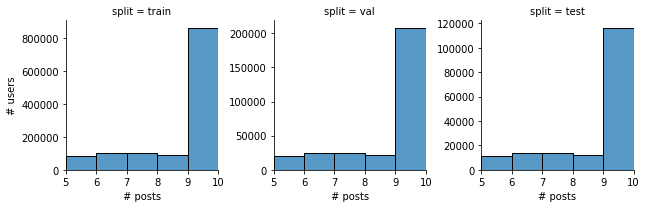

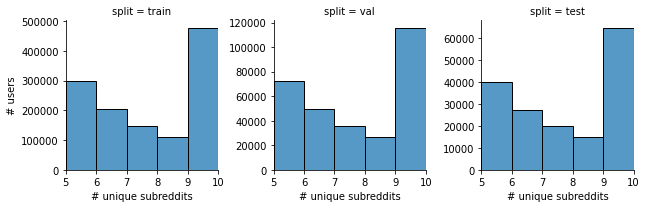

In [78]:
g = sns.displot(data=df[df['# posts']<=500], x='# posts', 
            kind='hist', col='split', binwidth=1, facet_kws={'sharey':False},
            height=3, col_order=['train','val','test'])
for i,a in enumerate(g.axes[0]):
    if i==0:
        a.set_ylabel('# users')
    else:
        a.set_ylabel('')
    a.set_xlim(5, 10)
    a.ticklabel_format(axis='both', style='plain')
h = sns.displot(data=df[df['# subreddits']<=500], x='# subreddits', 
            kind='hist', col='split', binwidth=1, facet_kws={'sharey':False},
            height=3, col_order=['train','val','test'])
for i, a in enumerate(h.axes[0]):
    a.set_xlim(5, 10)
    if i==0:
        a.set_ylabel('# users')
    else:
        a.set_ylabel('')
    a.ticklabel_format(axis='both', style='plain')
    a.set_xlabel('# unique subreddits')